see https://examples.dask.org/dataframe.html

In [2]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62124,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:62135,Total threads: 2
Dashboard: http://127.0.0.1:62136/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:62127,


In [3]:
import dask
df = dask.datasets.timeseries()
df

c:\Projects\dataframe-apis\venv\Lib\site-packages\dask_expr\_collection.py:5983: UserWarning: dask_expr does not support the DataFrameIOFunction protocol for column projection. To enable column projection, please ensure that the signature of `func` includes a `columns=` keyword argument instead.
  warnings.warn(


,name,id,x,y
npartitions=30,,,,
2000-01-01,string,int32,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [4]:
# This sets some formatting parameters for displayed data.
import pandas as pd

pd.options.display.precision = 2
pd.options.display.max_rows = 10

df.head(3)

,name,id,x,y
timestamp,,,,
2000-01-01 00:00:00,Alice,985,9.08e-01,0.70
2000-01-01 00:00:01,Bob,963,3.16e-01,-0.53
2000-01-01 00:00:02,Charlie,989,-9.48e-03,0.15


In [5]:
df2 = df[df.y > 0]
df3 = df2.groupby("name").x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=(((Filter(frame=ArrowStringConversion(frame=FromMap(ae8940e)), predicate=ArrowStringConversion(frame=FromMap(ae8940e))['y'] > 0))[['name', 'x']]).std(ddof=1, numeric_only=False, split_out=None, observed=False))['x']

In [6]:
computed_df = df3.compute()
type(computed_df)
computed_df

2024-09-01 11:59:08,797 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle dbf2727832b19d402a0e51c8445678f9 initialized by task ('shuffle-transfer-dbf2727832b19d402a0e51c8445678f9', 9) executed on worker tcp://127.0.0.1:62135
2024-09-01 11:59:11,414 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle dbf2727832b19d402a0e51c8445678f9 deactivated due to stimulus 'task-finished-1725217151.4136934'
2024-09-01 11:59:28,119 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 267a878987c5a84c0388228ee7c8b4ef initialized by task ('shuffle-transfer-267a878987c5a84c0388228ee7c8b4ef', 23) executed on worker tcp://127.0.0.1:62138
2024-09-01 11:59:29,382 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 267a878987c5a84c0388228ee7c8b4ef deactivated due to stimulus 'task-finished-1725217169.3821049'
2024-09-01 11:59:45,066 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 267a878987c5a84c0388228ee7c8b4ef initialized by task ('shuffle-transfer-267a878987c5a

name
Bob         0.58
Dan         0.58
Edith       0.58
George      0.58
Hannah      0.58
            ... 
Patricia    0.58
Tim         0.58
Ursula      0.58
Victor      0.58
Xavier      0.58
Name: x, Length: 26, dtype: float64

In [7]:
df4 = df.groupby("name").aggregate({"x": "sum", "y": "max"})
df4.compute()

,x,y
name,,
Alice,-57.46,1.0
Patricia,246.86,1.0
Sarah,-236.73,1.0
Ingrid,-454.39,1.0
Kevin,-176.72,1.0
...,...,...
Edith,-47.96,1.0
Tim,58.34,1.0
Ray,244.87,1.0


In [8]:
df4 = df4.repartition(npartitions=1)
joined = df.merge(
    df4, left_on="name", right_index=True, suffixes=("_original", "_aggregated")
)
joined.head()

,name,id,x_original,y_original,x_aggregated,y_aggregated
timestamp,,,,,,
2000-01-01 00:00:00,Alice,985,9.08e-01,0.70,-57.46,1.0
2000-01-01 00:00:01,Bob,963,3.16e-01,-0.53,-48.84,1.0
2000-01-01 00:00:02,Charlie,989,-9.48e-03,0.15,-146.62,1.0
2000-01-01 00:00:03,Charlie,1005,6.59e-01,-0.94,-146.62,1.0
2000-01-01 00:00:04,Alice,1025,-9.57e-01,-0.81,-57.46,1.0


In [9]:
df = df.persist()

In [10]:
df[["x", "y"]].resample("1h").mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,6.31e-03,-7.02e-03
2000-01-01 01:00:00,-6.73e-03,1.98e-03
2000-01-01 02:00:00,7.90e-03,7.87e-03
2000-01-01 03:00:00,-6.38e-03,-1.41e-02
2000-01-01 04:00:00,-2.85e-04,-2.54e-03


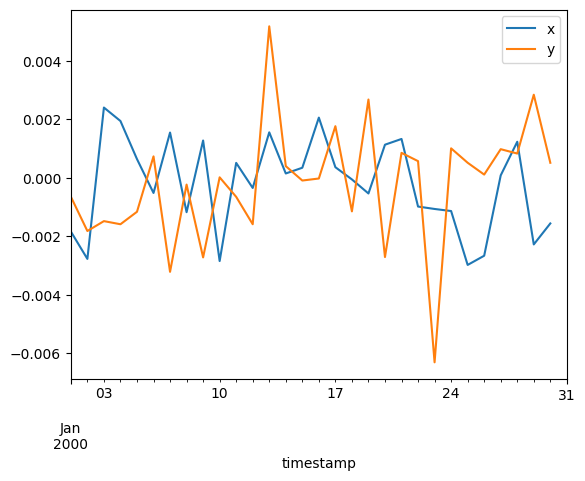

In [11]:
%matplotlib inline
df[['x', 'y']].resample('24h').mean().compute().plot();

In [12]:
df[["x", "y"]].rolling(window="24h").mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,0.91,0.70
2000-01-01 00:00:01,0.61,0.09
2000-01-01 00:00:02,0.40,0.11
2000-01-01 00:00:03,0.47,-0.15
2000-01-01 00:00:04,0.18,-0.29
